In [1]:
%matplotlib inline

In [2]:
# Default imports.
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Drawing imports.
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap

# Others.
from difflib import SequenceMatcher
from scipy.stats import f_oneway, ttest_ind

# Custom.
import food_fact_features

# To brew or not to brew
## Exploring beers - craft, homemade and in-store
## Author: Mihail Milev

***

### Abstract

Some time ago one of my American colleagues, let's call him Rob, told me that brewing in the US is becoming very popular. Some states have become packed with small breweries producing their own craft beer. On the other hand a lot of people have bought expensive equipment and have started brewing at home - as a hobby.

Not that I do not trust Rob, but what is the extent of this process and how different the produce is? And also - how is the craft and homemade beer different from the one sold in-store. That's what we'll try to find out in this data science beer adventure - hop in!

### Craft beers and breweries

Luckily I've found a great dataset at Kaggle - the [Craft Cans dataset](https://www.kaggle.com/nickhould/craft-cans). A small excerpt from the Overview section:

> It's a great time to be a craft beer fan in the U.S.! There are a ton of beer styles and brands to choose from and breweries have become very successful in the last several years. Breweries owe it all to beer lovers around the world! This dataset contains a list of 2,410 US craft beers and 510 US breweries. This data was collected in January 2017 from CraftCans.com.

In [3]:
craft_beers = pd.read_csv('data/craft-cans/beers.csv', index_col=0)
breweries = pd.read_csv('data/craft-cans/breweries.csv', header=0, names=['brewery_id', 'name', 'city', 'state'])

#### Brewery clean up

Let's start with the breweries. What do we have here?

In [4]:
def columns_to_category(data, columns):
    """
    Converts all specified columns in the data argument to a category (in place).
    
    Args:
        data (pandas.DataFrame): DataFrame to convert.
        columns (list): Columns to be converted.
    """
    for col in columns:
        data[col] = data[col].str.strip().astype(dtype='category')

In [5]:
test_frame = pd.DataFrame({'A': ['a ', 'b']})
assert test_frame['A'].dtype.name == 'object'
columns_to_category(test_frame, ['A'])
assert test_frame['A'].dtype.name == 'category'
assert test_frame['A'].tolist() == ['a', 'b']

In [6]:
# Having categories instead of string objects won't hurt...
columns_to_category(breweries, ['name', 'city', 'state'])
breweries.head()

,brewery_id,name,city,state
0,0,NorthGate Brewing,Minneapolis,MN
1,1,Against the Grain Brewery,Louisville,KY
2,2,Jack's Abby Craft Lagers,Framingham,MA
3,3,Mike Hess Brewing Company,San Diego,CA
4,4,Fort Point Beer Company,San Francisco,CA


It appears that the state column contains the state abbreviation and not the name. This is not very convenient so let's fix it by using the states dataset (located in data/us-states, thanks Yordan Darakchiev).

In [7]:
state_names = pd.read_csv('data/us-states/names.csv')
state_names_map = {state['abbreviation']: state['name'] for index, state in state_names.iterrows()}
breweries['state'].replace(state_names_map, inplace=True)
breweries.head()

,brewery_id,name,city,state
0,0,NorthGate Brewing,Minneapolis,Minnesota
1,1,Against the Grain Brewery,Louisville,Kentucky
2,2,Jack's Abby Craft Lagers,Framingham,Massachusetts
3,3,Mike Hess Brewing Company,San Diego,California
4,4,Fort Point Beer Company,San Francisco,California


That's better.

#### Brewery count by state

Which states should I visit when I go visiting Rob in the US?

In [8]:
brewery_count_by_state = breweries['state'].value_counts()

In [9]:
def draw_bars(count_series, title, xlabel, ylabel):
    """
    Plots a bar chart with a horizontal line representing the mean value.
    
    Args:
        count_series (pandas.Series): Data to plot.
        title (str): Plot title.
        xlabel (str): X-axis label.
        ylabel (str): Y-axis label.
    """
    state_count = len(count_series)
    plt.figure(figsize=(15, 10))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(list(range(0, state_count)), rotation='vertical')
    plt.bar(count_series.index.tolist(), count_series.values.tolist())
    plt.gca().axhline(y=count_series.mean(), color='r', label='Average count')
    plt.legend()
    plt.show()

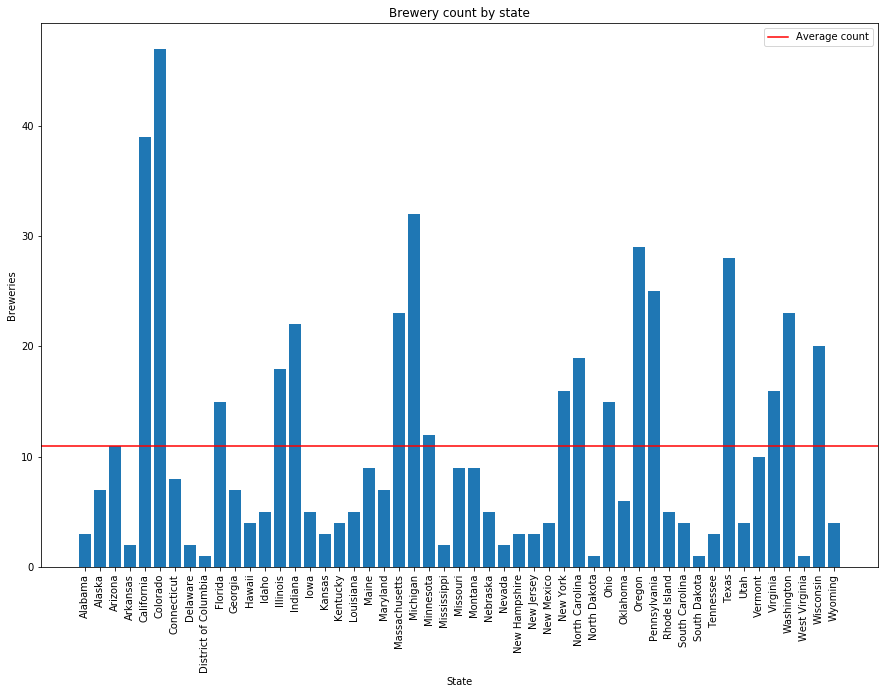

In [10]:
draw_bars(brewery_count_by_state, 'Brewery count by state', 'State', 'Breweries')

Colorado and California are the obvious winners. Well that's great if I know where each state is located but unfortunately - I am not that good in geography.

#### Brewery density map

Let's draw a choroplet map!

The first thing we'll need to draw it is a set of shape files that define each state boundary. I've already downloaded some into the data folder (downloaded from [github](https://github.com/matplotlib/basemap/tree/master/examples)).

Next - we need a way to map brewery count to certain color that represents it properly - the more breweries in a state the more intense the color should be.

In [11]:
def count_to_color(count, count_min, count_max, choose_color):
    """
    Converts a count into an RGB color tuple.
    The min and max values are used to choose a color proportional to the count.
    
    Args:
        count (int): Count to convert.
        count_min (int): Lower count boundary mapped to 0.
        count_max (int): Upper count boundary mapped to 1.
        choose_color (function): Function that converts a number between 0 and 1 to color.
    
    Returns:
        tuple: The RGB color.
    """
    # Generate a number from 0 to 1 so we can map it to a color.
    proportion = 0.0
    if count_min < count <= count_max:
        # Make sure that proportions are spread evenly (sqrt for the win!).
        proportion = np.sqrt((count - count_min) / (count_max - count_min))
    elif count > count_max:
        proportion = 1.0
    
    # Strip the alpha channel from the result colors.
    return choose_color(proportion)[:3]

In [12]:
assert rgb2hex(count_to_color(10, 20, 30, plt.cm.Greys)) == '#ffffff'
assert rgb2hex(count_to_color(40, 20, 30, plt.cm.Greys)) == '#000000'
assert rgb2hex(count_to_color(25, 20, 30, plt.cm.Greys)) == '#5d5d5d'

Luckily we've heard about code reusability so let's make a plotting function to draw our choropleth map.

In [13]:
def draw_states_choropleth_map(count_series, title):
    """
    Draws a choropleth map of the US states based on a pandas Series.
    
    Args:
        count_series (pandas.Series): Data to plot.
        title (str): Plot title.
    """
    # Initialize the count boundaries necessary for color mappings.
    count_min = count_series.min()
    count_max = count_series.max()

    # Initialize the map.
    figure = plt.figure(figsize=(15, 10))
    choropleth_map = Basemap(projection='merc', llcrnrlon=-130, llcrnrlat=23, urcrnrlon=-64, urcrnrlat=50)
    choropleth_map.readshapefile('data/us-states/st99_d00', 'states', drawbounds=True)

    # The shapefile contains 273 shapes (some states have multiple) - map those to colors.
    shape_colors = []
    choose_color = plt.cm.YlOrBr
    for state_info in choropleth_map.states_info:
        state = state_info['NAME']
        count = 0
        if state in count_series.index:
            count = count_series.loc[state]
        color = count_to_color(count, count_min, count_max, choose_color)
        shape_colors.append(color)

    # Add colors to the map.
    axes = plt.gca()
    for shape_number, xy in enumerate(choropleth_map.states):
        color = rgb2hex(shape_colors[shape_number])
        polygon = Polygon(xy, facecolor=color, edgecolor=color)
        axes.add_patch(polygon)

    plt.title(title)
    colorbar_axes = figure.add_axes([0.95, 0.15, 0.02, 0.7])
    matplotlib.colorbar.ColorbarBase(colorbar_axes, cmap=choose_color,
                                     norm=matplotlib.colors.Normalize(count_min, count_max))
    plt.show()

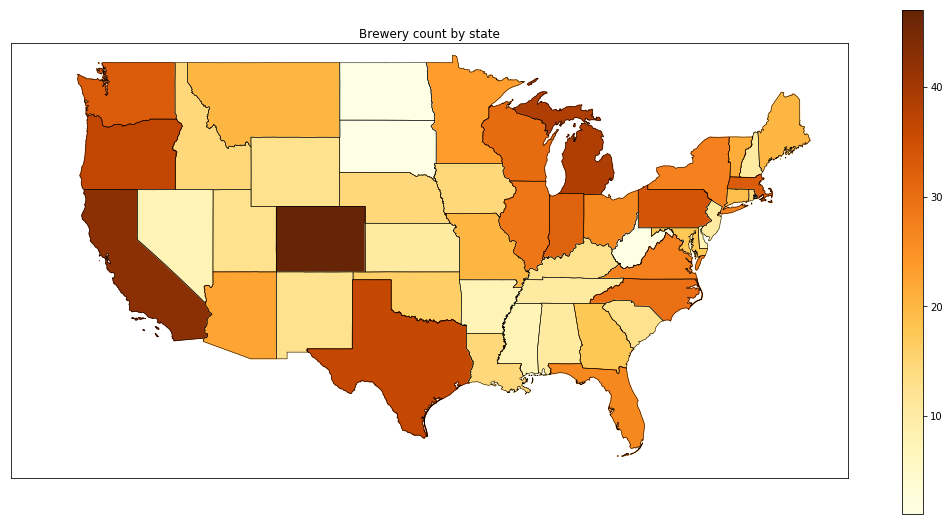

In [14]:
draw_states_choropleth_map(brewery_count_by_state, 'Brewery count by state')

#### Craft beer clean up

We also have more than 2500 beers in the dataset, remember? Let's check them out too.

In [15]:
craft_beers.head()

,abv,ibu,id,name,style,brewery_id,ounces
0,0.050,NaN,1436,Pub Beer,American Pale Lager,408,12.0
1,0.066,NaN,2265,Devil's Cup,American Pale Ale (APA),177,12.0
2,0.071,NaN,2264,Rise of the Phoenix,American IPA,177,12.0
3,0.090,NaN,2263,Sinister,American Double / Imperial IPA,177,12.0
4,0.075,NaN,2262,Sex and Candy,American IPA,177,12.0


Since the index in the breweries dataset is actually the brewery id - let's merge the datasets and clean them up a little bit.

In [16]:
craft_beers = craft_beers.merge(breweries, on='brewery_id')

# Rename the name collumns. After the merge they look like name_x and name_y by default.
craft_beers.rename(columns={'name_x': 'beer_name', 'name_y': 'brewery_name'}, inplace=True)

# Drop ids - we do not need them anymore.
craft_beers.drop(['id', 'brewery_id'], axis=1, inplace=True)

# Tydiness makes me happy so let's reorder.
craft_beers = craft_beers[['brewery_name', 'city', 'state', 'beer_name', 'style', 'ounces', 'abv', 'ibu']]

# Some columns can be converted to categories.
columns_to_category(craft_beers, ['style'])
    
# Convert ABV (Alcohol by volume) to percentage to make our life easier.
craft_beers['abv'] = craft_beers['abv'] * 100
craft_beers.rename(columns={'abv': 'alcohol'}, inplace=True)

In [17]:
craft_beers.head()

,brewery_name,city,state,beer_name,style,ounces,alcohol,ibu
0,10 Barrel Brewing Company,Bend,Oregon,Pub Beer,American Pale Lager,12.0,5.0,NaN
1,18th Street Brewery,Gary,Indiana,Devil's Cup,American Pale Ale (APA),12.0,6.6,NaN
2,18th Street Brewery,Gary,Indiana,Rise of the Phoenix,American IPA,12.0,7.1,NaN
3,18th Street Brewery,Gary,Indiana,Sinister,American Double / Imperial IPA,12.0,9.0,NaN
4,18th Street Brewery,Gary,Indiana,Sex and Candy,American IPA,12.0,7.5,NaN


Now that's better. By the way if you wonder what IBU is (as I did) - it is International bittering units, which describe how bitter a drink is:

> Bitterness scales attempt to rate the perceived relative bitterness of beer. The bitterness of beer is provided by compounds such as humulones, or alpha acids from hops used during brewing. During the brewing process, humulone undergoes isomerization to form both cis- and trans- isohumulone which are responsible for the bitter taste of the beer.

More info on [wikipedia](https://en.wikipedia.org/wiki/Beer_measurement).

#### Craft beer count by state

We already saw which states have most breweries but where can we find the biggest variety?

In [18]:
craft_beer_count_by_state = craft_beers['state'].value_counts()

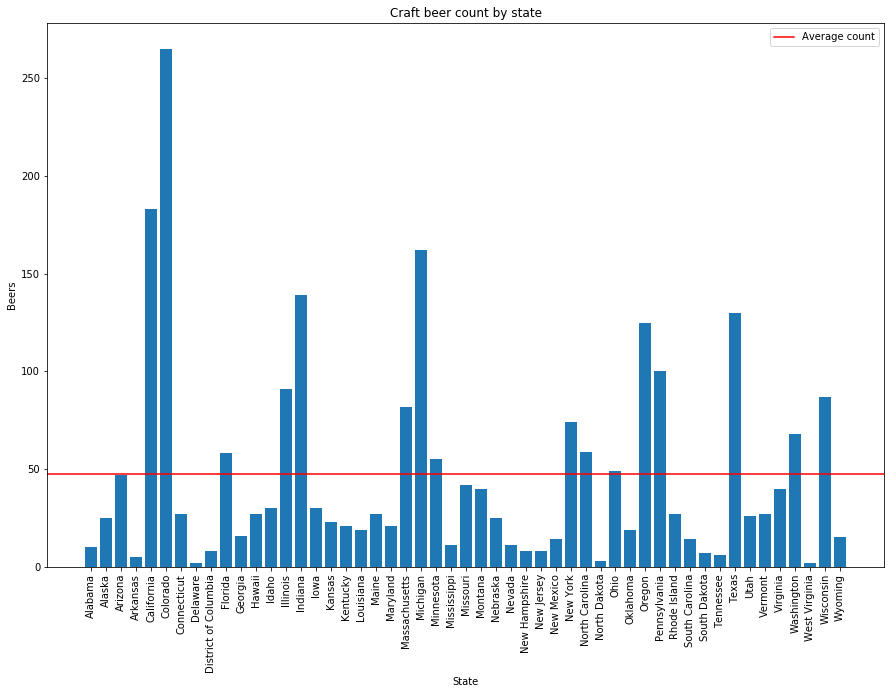

In [19]:
draw_bars(craft_beer_count_by_state, 'Craft beer count by state', 'State', 'Beers')

#### Craft beer density map

Luckily we have created some tools so far so we can draw more easily.

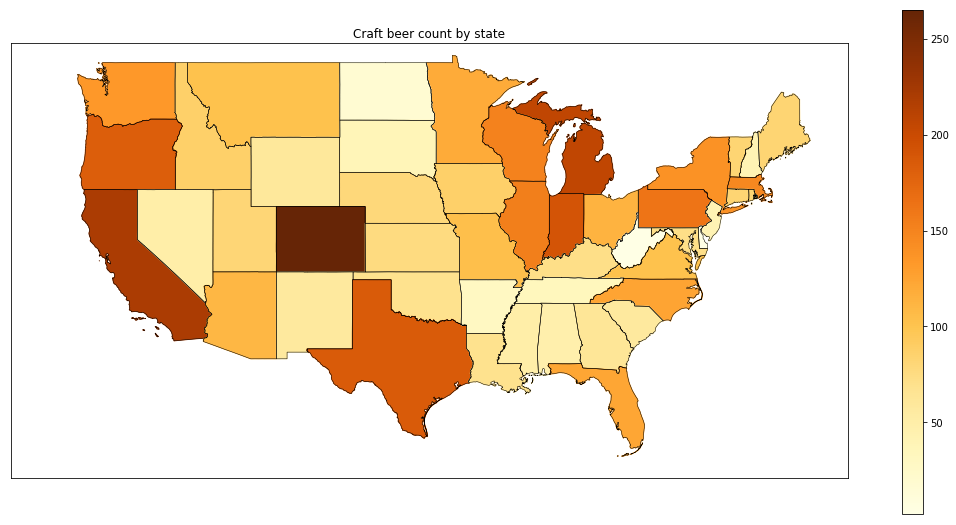

In [20]:
draw_states_choropleth_map(craft_beer_count_by_state, 'Craft beer count by state')

Surprised? They look very similar. Let's check how much exactly.

In [21]:
matcher = SequenceMatcher(None, brewery_count_by_state.index.tolist(), craft_beer_count_by_state.index.tolist())
round(matcher.ratio(), 3)

0.471

So what does this mean? Well actually the states are ordered quite differently (1 means exactly the same). So although the maps are similar (because counts are), it does not mean that states share the same position in both ratings.

#### Craft beer count by style

What about the beer style - anything prefered or most popular?

In [22]:
craft_beer_count_by_style = craft_beers['style'].value_counts()

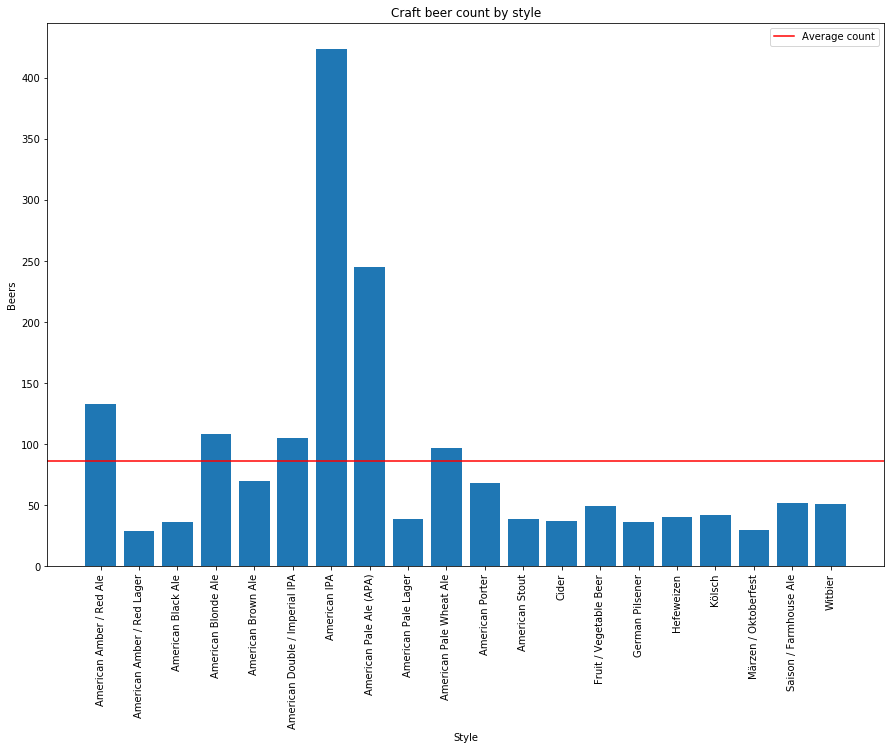

In [23]:
draw_bars(craft_beer_count_by_style[:20], 'Craft beer count by style', 'Style', 'Beers')

So if you go to a brewery in the US - you must try American IPA and American Pale Ale for sure! Note taken.

#### Craft beer alcohol - bitterness correlation

Another interesting question is whether alcohol and IBU are somehow related. We will remove all empty values to compare them.

In [24]:
craft_beers = craft_beers.dropna(subset=['alcohol', 'ibu'])
craft_beers[['alcohol', 'ibu']].corr()

,alcohol,ibu
alcohol,1.000000,0.670621
ibu,0.670621,1.000000


The numbers say that there might be some relation but I am not convinced yet. Let's draw a scatter plot.

In [25]:
def draw_scatter(data, x, y, title):
    """
    Draws a scatter plot.
    
    Args:
        data (pandas.DataFrame): Data to plot.
        x (str): X-axis label and data frame feature.
        y (str): Y-axis label and data frame feature.
        title (str): Plot title.
    """
    plt.figure(figsize=(15, 10))
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.scatter(data[x.lower()], data[y.lower()])
    plt.show()

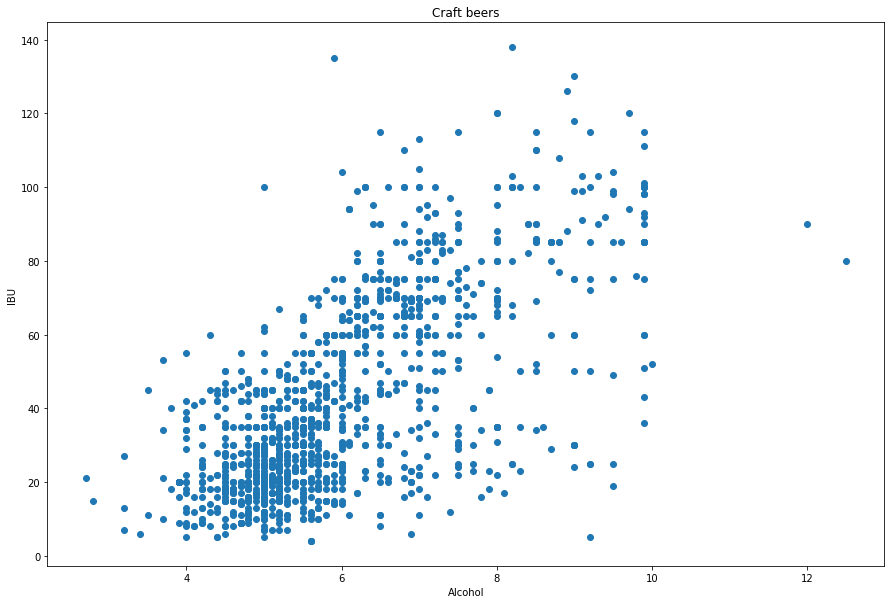

In [26]:
draw_scatter(craft_beers, 'Alcohol', 'IBU', 'Craft beers')

Erm... Still not quite sure... We'll try something else. Our null hypothesis will be that there is no relation between the variables - stronger beers are not more bitter than the lighter beers. Let's try to prove it.

In [27]:
def split_by_alcohol_category(beers, column):
    """
    Splits beers into 2 alcohol categories - strong and light.
    
    Args:
        beers (pandas.DataFrame): Beers to split.
        column (str): Column to select and return.
    
    Returns:
        tuple: The string and light beer DataFrame objects.
    """
    alcohol_mean = beers['alcohol'].mean()
    strong_beers = beers[beers['alcohol'] >= alcohol_mean][[column]].dropna()
    light_beers = beers[beers['alcohol'] < alcohol_mean][[column]].dropna()
    return (strong_beers, light_beers)

In [28]:
test_strong, test_light = split_by_alcohol_category(pd.DataFrame({
    'alcohol': [2, 2, 2, 6],
    'ibu': [1, 1, 1, 10]
}), 'ibu')
assert len(test_strong) == 1
assert test_strong['ibu'].tolist() == [10]
assert len(test_light) == 3
assert test_light['ibu'].tolist() == [1, 1, 1]

In [29]:
strong_craft_beers, light_craft_beers = split_by_alcohol_category(craft_beers, 'ibu')
print('Strong craft beer count %d.' % len(strong_craft_beers))
print('Light craft beer count %d.' % len(light_craft_beers))

Strong craft beer count 601.
Light craft beer count 804.


Our sample size looks well distributed. That's good.

In [30]:
f_oneway(strong_craft_beers['ibu'], light_craft_beers['ibu'])

F_onewayResult(statistic=1061.5643510494106, pvalue=7.3460784992994427e-174)

Wow! That's a great p-value. It looks like there is a relation after all.

### Homebrewed beer recipes

We got familiar with the breweries and the craft beers they make. What about the people that brew at home? To explore that topic we will use another dataset - [Brewer's Friend Beer Recipes](https://www.kaggle.com/jtrofe/beer-recipes) (found on Kaggle again, thank you Kaggle). A small excerpt from the Overview section:

> This is a dataset of 75,000 homebrewed beers with over 176 different styles. Beer records are user-reported and are classified according to one of the 176 different styles. These recipes go into as much or as little detail as the user provided, but there's at least 5 useful columns where data was entered for each: Original Gravity, Final Gravity, ABV, IBU, and Color.

In [31]:
home_beers = pd.read_csv('data/beer-recipes/recipes.csv', encoding='latin-1')
home_styles = pd.read_csv('data/beer-recipes/styles.csv', encoding='latin-1')

#### Homebrewed beer clean up

Let's see what the data looks like.

In [32]:
home_beers.head()

,BeerID,Name,URL,Style,StyleID,Size(L),OG,FG,ABV,IBU,...,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount,UserId
0,1,Vanilla Cream Ale,/homebrew/recipe/view/1633/vanilla-cream-ale,Cream Ale,45,21.77,1.055,1.013,5.48,17.65,...,1.038,70.0,NaN,Specific Gravity,All Grain,NaN,17.78,corn sugar,4.5 oz,116.0
1,2,Southern Tier Pumking clone,/homebrew/recipe/view/16367/southern-tier-pumk...,Holiday/Winter Special Spiced Beer,85,20.82,1.083,1.021,8.16,60.65,...,1.070,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,955.0
2,3,Zombie Dust Clone - EXTRACT,/homebrew/recipe/view/5920/zombie-dust-clone-e...,American IPA,7,18.93,1.063,1.018,5.91,59.25,...,NaN,70.0,NaN,Specific Gravity,extract,NaN,NaN,NaN,NaN,NaN
3,4,Zombie Dust Clone - ALL GRAIN,/homebrew/recipe/view/5916/zombie-dust-clone-a...,American IPA,7,22.71,1.061,1.017,5.80,54.48,...,NaN,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,NaN
4,5,Bakke Brygg Belgisk Blonde 50 l,/homebrew/recipe/view/89534/bakke-brygg-belgis...,Belgian Blond Ale,20,50.00,1.060,1.010,6.48,17.84,...,1.050,72.0,NaN,Specific Gravity,All Grain,NaN,19.00,Sukkerlake,6-7 g sukker/l,18325.0


In [33]:
home_styles.head()

,Style,StyleID
0,Altbier,1
1,Alternative Grain Beer,2
2,Alternative Sugar Beer,3
3,American Amber Ale,4
4,American Barleywine,5


Well - it can be better, let's make column names pythonic and remove the ones that are not interesting for our research.

In [34]:
home_styles = home_styles.rename(columns={'Style': 'name', 'StyleID': 'id'})
home_styles = home_styles.set_index('id')

In [35]:
home_styles.head()

,name
id,
1,Altbier
2,Alternative Grain Beer
3,Alternative Sugar Beer
4,American Amber Ale
5,American Barleywine


In [36]:
home_beers = home_beers.drop(['URL', 'Size(L)', 'BoilSize', 'Efficiency', 'MashThickness',
                              'SugarScale', 'PitchRate', 'PrimaryTemp', 'PrimingMethod',
                              'PrimingAmount', 'UserId'], axis=1)
home_beers = home_beers.rename(columns={
    'BeerID': 'id',
    'Name': 'name',
    'Style': 'style',
    'StyleID': 'style_id',
    'OG': 'original_gravity',
    'FG': 'final_gravity',
    'ABV': 'alcohol',
    'IBU': 'ibu',
    'Color': 'color',
    'BoilTime': 'boil_time',
    'BoilGravity': 'boil_gravity',
    'BrewMethod': 'brew_method'
})
home_beers = home_beers.set_index('id')

In [37]:
home_beers.head()

,name,style,style_id,original_gravity,final_gravity,alcohol,ibu,color,boil_time,boil_gravity,brew_method
id,,,,,,,,,,,
1,Vanilla Cream Ale,Cream Ale,45,1.055,1.013,5.48,17.65,4.83,75,1.038,All Grain
2,Southern Tier Pumking clone,Holiday/Winter Special Spiced Beer,85,1.083,1.021,8.16,60.65,15.64,60,1.070,All Grain
3,Zombie Dust Clone - EXTRACT,American IPA,7,1.063,1.018,5.91,59.25,8.98,60,NaN,extract
4,Zombie Dust Clone - ALL GRAIN,American IPA,7,1.061,1.017,5.80,54.48,8.50,60,NaN,All Grain
5,Bakke Brygg Belgisk Blonde 50 l,Belgian Blond Ale,20,1.060,1.010,6.48,17.84,4.57,90,1.050,All Grain


That's more like it but still not great. Do we actually need that style_id column?

In [38]:
assert set(home_styles['name'].unique().tolist()) == set(home_beers['style'].unique().tolist())

Nice - let's get rid of the style_id. This is actually really great - we won't need the beer_styles dataset at all. Let's fix some data types too.

In [39]:
home_beers = home_beers.drop('style_id', axis=1)
columns_to_category(home_beers, ['style', 'brew_method'])

In [40]:
home_beers.head()

,name,style,original_gravity,final_gravity,alcohol,ibu,color,boil_time,boil_gravity,brew_method
id,,,,,,,,,,
1,Vanilla Cream Ale,Cream Ale,1.055,1.013,5.48,17.65,4.83,75,1.038,All Grain
2,Southern Tier Pumking clone,Holiday/Winter Special Spiced Beer,1.083,1.021,8.16,60.65,15.64,60,1.070,All Grain
3,Zombie Dust Clone - EXTRACT,American IPA,1.063,1.018,5.91,59.25,8.98,60,NaN,extract
4,Zombie Dust Clone - ALL GRAIN,American IPA,1.061,1.017,5.80,54.48,8.50,60,NaN,All Grain
5,Bakke Brygg Belgisk Blonde 50 l,Belgian Blond Ale,1.060,1.010,6.48,17.84,4.57,90,1.050,All Grain


#### Homebrewed beer alcohol - bitterness correlation

Our craft beer alcohol - IBU correlation test gave great results. Let's see if we can confirm it here too.

In [41]:
home_beers[['alcohol', 'ibu']].corr()

,alcohol,ibu
alcohol,1.000000,0.290889
ibu,0.290889,1.000000


Hmmm... I'm getting suspicious - maybe our craft beer result war wrong? Let's see the data on a chart.

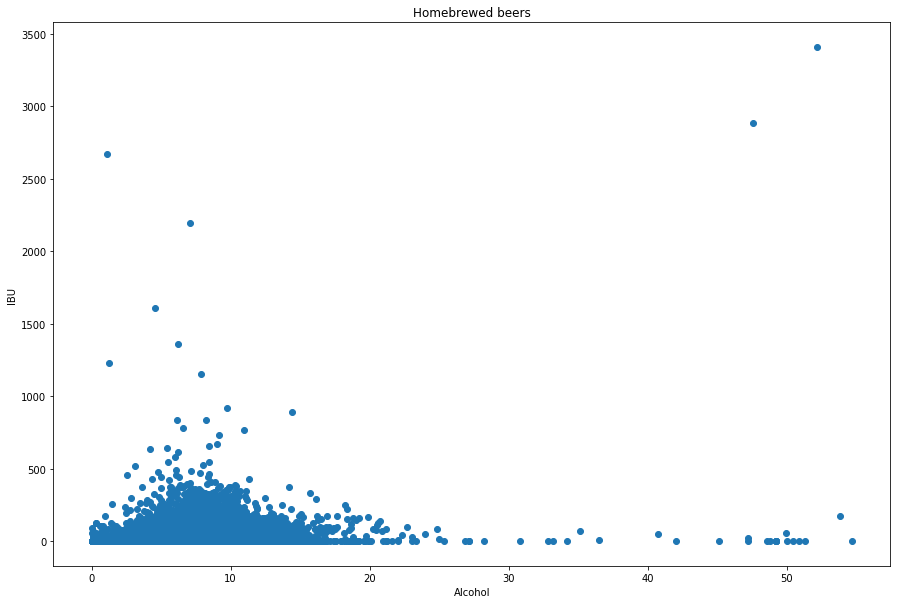

In [42]:
draw_scatter(home_beers, 'Alcohol', 'IBU', 'Homebrewed beers')

That's quite different. 20+ alcohol in a beer? Let's google it?

Ok - it appears that there is such thing actually - the strongest beer in the world is called Brewmeister Snake Venom 67.5% (info taken from [The Highest ABV Beers You Can Buy](https://proof.media/the-highest-abv-beers-you-can-buy)).

And what about the bitternes? According to [this article](https://beerconnoisseur.com/articles/whats-meaning-ibu) there is some kind of a competition between brewers to achieve the highest value possible. Those values are actually not outliers but I think we can consider them as such since they are very extreme and are not "normal" every day beer.

Let's try again but with a smaller dataset excluding the extremes. We will use the maximum alcohol value from the craft beer dataset as the alcohol limit and 110 as the bitterness limit. Quote from the article about IBU:

> What none of these breweries explicitly state is that the human palate can only distinguish up to around 110 IBUs before it tucks into its shell and retreats down the esophagus.

In [43]:
craft_beer_max_alcohol = craft_beers['alcohol'].max()
home_regular_beers = home_beers[(home_beers['ibu'] < 110) & (home_beers['alcohol'] < craft_beer_max_alcohol)]

In [44]:
home_regular_beers[['alcohol', 'ibu']].corr()

,alcohol,ibu
alcohol,1.000000,0.349658
ibu,0.349658,1.000000


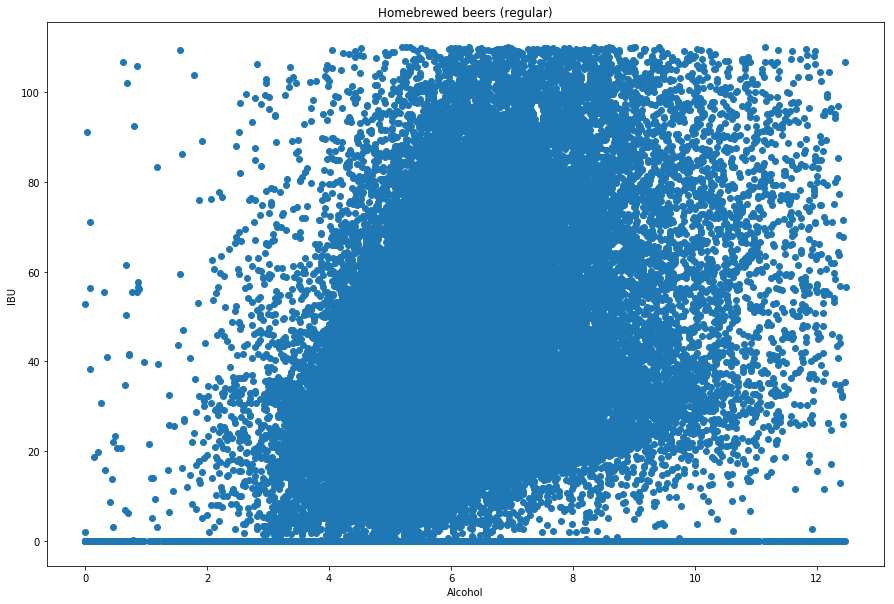

In [45]:
draw_scatter(home_regular_beers, 'Alcohol', 'IBU', 'Homebrewed beers (regular)')

We have one last resort - the hypothesis test.

In [46]:
strong_home_beers, light_home_beers = split_by_alcohol_category(home_beers, 'ibu')
print('Strong homebrewed beer count %d.' % len(strong_home_beers))
print('Light homebrewed beer count %d.' % len(light_home_beers))

Strong homebrewed beer count 29492.
Light homebrewed beer count 44369.


In [47]:
f_oneway(strong_home_beers['ibu'], light_home_beers['ibu'])

F_onewayResult(statistic=6744.1543390453198, pvalue=0.0)

Is this what it looks like? Nice!

#### Homebrewed beer alcohol - color correlation

Then... can we actually also check for a relation between color and alcohol - maybe there is one too. As mentioned on [wikipedia](https://en.wikipedia.org/wiki/Beer_measurement) (under the color section) beer color is measured in numbers where 1 is light and anything above 40 is really dark.

In [48]:
home_beers[['alcohol', 'color']].corr()

,alcohol,color
alcohol,1.000000,0.271332
color,0.271332,1.000000


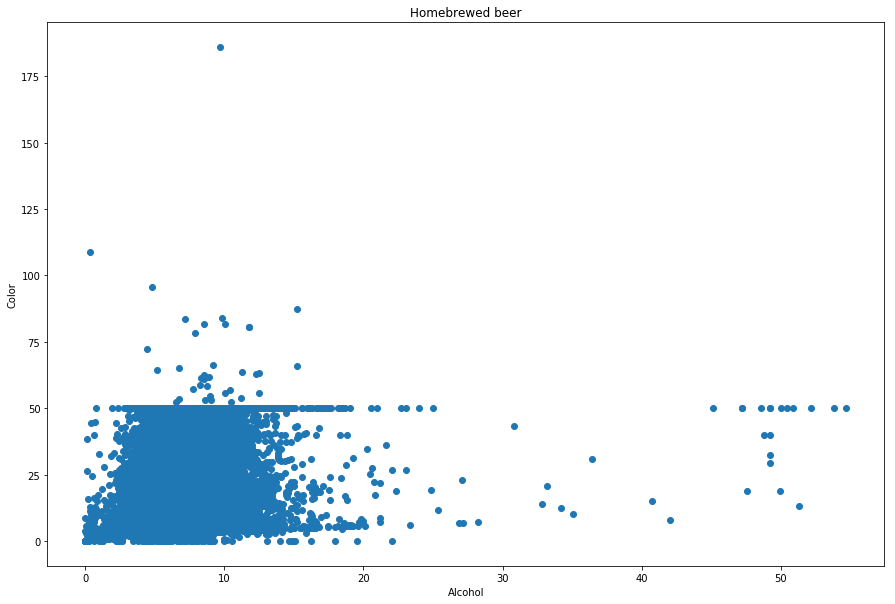

In [49]:
draw_scatter(home_beers, 'Alcohol', 'Color', 'Homebrewed beer')

Nothing super special but let's try ANOVA again.

In [50]:
strong_home_beers, light_home_beers = split_by_alcohol_category(home_beers, 'color')
print('Strong homebrewed beer count %d.' % len(strong_home_beers))
print('Light homebrewed beer count %d.' % len(light_home_beers))

Strong homebrewed beer count 29492.
Light homebrewed beer count 44369.


In [51]:
f_oneway(strong_home_beers['color'], light_home_beers['color'])

F_onewayResult(statistic=3176.973258269808, pvalue=0.0)

Wow! Another correlation discovered - darker beers have a higher chance of being strong but who didn't know that already.

Side note: if you wonder what are those gravity columns in a beer brewing context read on [wikipedia](https://en.wikipedia.org/wiki/Gravity_%28alcoholic_beverage%29). In short:

> The difference between the original gravity of the wort and the final gravity of the beer is an indication of how much sugar has been turned into alcohol. The bigger the difference, the greater the amount of alcohol present and hence the stronger the beer. This is why strong beers are sometimes referred to as high gravity beers, and "session" or "small" beers are called low gravity beers, even though in theory the final gravity of a strong beer might be lower than that of a session beer because of the greater amount of alcohol present.

We could try to prove it based on the data we have but let's leave it for later (if there is time of course).

#### Craft beer alcohol - homebrewed beer alcohol correlation

Now let's try to correlate the two datasets. We well compare alcohol between craft beers and homemade ones based on beer style.

In [52]:
home_beers.head()

,name,style,original_gravity,final_gravity,alcohol,ibu,color,boil_time,boil_gravity,brew_method
id,,,,,,,,,,
1,Vanilla Cream Ale,Cream Ale,1.055,1.013,5.48,17.65,4.83,75,1.038,All Grain
2,Southern Tier Pumking clone,Holiday/Winter Special Spiced Beer,1.083,1.021,8.16,60.65,15.64,60,1.070,All Grain
3,Zombie Dust Clone - EXTRACT,American IPA,1.063,1.018,5.91,59.25,8.98,60,NaN,extract
4,Zombie Dust Clone - ALL GRAIN,American IPA,1.061,1.017,5.80,54.48,8.50,60,NaN,All Grain
5,Bakke Brygg Belgisk Blonde 50 l,Belgian Blond Ale,1.060,1.010,6.48,17.84,4.57,90,1.050,All Grain


In [53]:
def group_beers_by_style(column, beers):
    """
    Groups beers by style and calculates count, mean and standard deviation for the column argument.
    Results are ordered by mean descendingly.
    
    Args:
        column (str): Calculate aggregations on.
        beers (pandas.DataFrame): Beers to group by style.
    
    Returns:
        pandas.DataFrame: The grouped beers.
    """
    grouped = beers[['style'] + [column]].dropna().groupby('style').agg(['count', 'mean', 'std'])
    grouped.columns = grouped.columns.get_level_values(1)
    return grouped.sort_values(by='mean', ascending=False)

In [54]:
test_frame = group_beers_by_style('alcohol', pd.DataFrame({
    'style': ['a', 'a', 'b', 'a', 'b'],
    'alcohol': [5, 6, 10, 4, 10]
}))
assert len(test_frame) == 2
assert test_frame.index.tolist() == ['b', 'a']
assert test_frame.columns.tolist() == ['count', 'mean', 'std']
assert test_frame['count'].tolist() == [2, 3]
assert test_frame['mean'].tolist() == [10, 5]
assert test_frame['std'].tolist() == [0.0, 1.0]

In [55]:
def merge_beers_by_style(column, *args):
    """
    Merges all passed beer datasets into a single data frame grouped by style.
    Count, mean and standard deviation are calculated for each beer dataset.
    
    Args:
        column (str): Calculate aggregations on.
        *args (pandas.DataFrame): Beer datasets to merge.
    
    Returns:
        pandas.DataFrame: The merged and aggregated datasets.
    """
    result = pd.DataFrame()
    if len(args):
        result = group_beers_by_style(column, args[0]).reset_index()
        for index in range(1, len(args)):
            to_add = group_beers_by_style(column, args[index]).reset_index()
            result = result.merge(to_add, on='style')
    return result.dropna()

In [56]:
test_frame = merge_beers_by_style('alcohol')
assert len(test_frame) == 0
test_frame = merge_beers_by_style('alcohol', pd.DataFrame({
    'style': ['a', 'a'],
    'alcohol': [1, 1]
}))
assert len(test_frame) == 1
assert test_frame.columns.tolist() == ['style', 'count', 'mean', 'std']
assert test_frame.loc[0].tolist() == ['a', 2, 1, 0.0]
test_frame = merge_beers_by_style('alcohol', pd.DataFrame({
    'style': ['a', 'a'],
    'alcohol': [1, 1]
}), pd.DataFrame({
    'style': ['a', 'a'],
    'alcohol': [5, 5]
}))
assert len(test_frame) == 1
assert test_frame.columns.tolist() == ['style', 'count_x', 'mean_x', 'std_x', 'count_y', 'mean_y', 'std_y']
assert test_frame.loc[0].tolist() == ['a', 2, 1, 0.0, 2, 5, 0.0]

In [57]:
beer_alcohol_by_style = merge_beers_by_style('alcohol', craft_beers, home_beers)

# Let's fix some of the column names.
beer_alcohol_by_style = beer_alcohol_by_style.rename(columns={
    'count_x': 'craft_count',
    'mean_x': 'craft_mean',
    'std_x': 'craft_std',
    'count_y': 'home_count',
    'mean_y': 'home_mean',
    'std_y': 'home_std'
})

beer_alcohol_by_style = beer_alcohol_by_style.dropna().set_index('style')
beer_alcohol_by_style

,craft_count,craft_mean,craft_std,home_count,home_mean,home_std
style,,,,,,
English Barleywine,3,10.766667,1.501111,253,10.573834,2.219363
Russian Imperial Stout,8,9.950000,0.888015,929,9.868698,1.918311
American Barleywine,2,9.900000,0.000000,341,10.599971,2.215698
Baltic Porter,3,9.366667,1.011599,344,7.374767,1.428976
Doppelbock,2,7.850000,0.494975,237,8.120549,1.563802
American Strong Ale,12,7.608333,0.467991,227,7.866256,1.391250
Bière de Garde,2,6.900000,0.000000,181,6.724475,1.004102
American IPA,301,6.480731,0.849447,11940,6.444294,1.205807
American Stout,16,6.137500,0.765833,1268,6.432153,1.741617


In [58]:
home_beer_count_by_style = home_beers['style'].value_counts()
print('We have %d style matches between %d craft styles and %d homebrewed styles.' % (
    len(beer_alcohol_by_style),
    len(craft_beer_count_by_style),
    len(home_beer_count_by_style)
))

We have 22 style matches between 99 craft styles and 175 homebrewed styles.


Eh... This is not very good but it would take us some time to manually fix the differences so... Let's just analyze what we have.

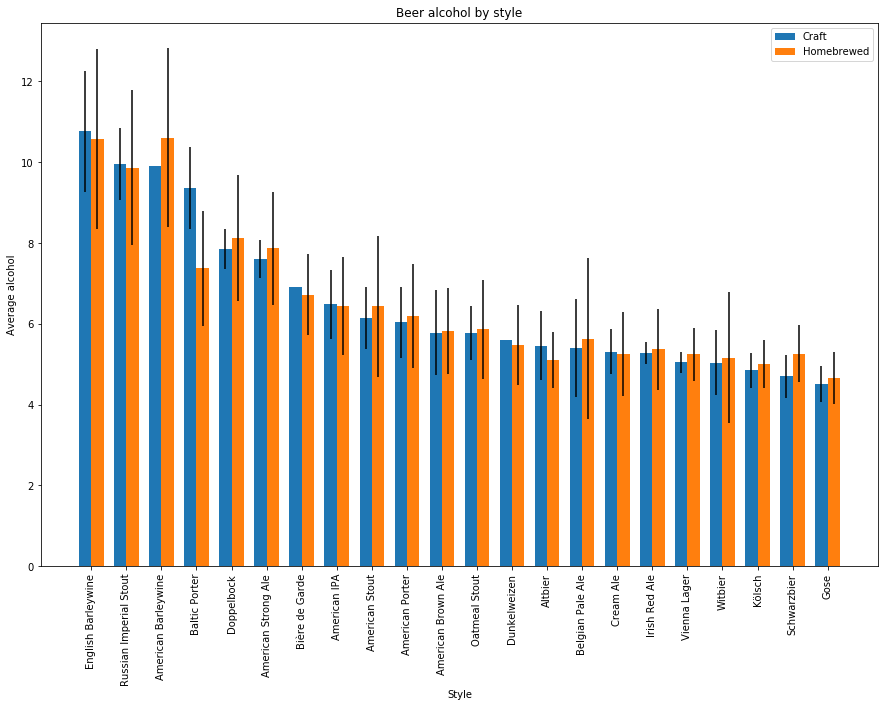

In [59]:
# Initialize some helpers.
style_count = len(beer_alcohol_by_style)
indexes = np.arange(style_count)
bar_width = 0.35

# Decorate the chart.
plt.figure(figsize=(15, 10))
plt.title('Beer alcohol by style')
plt.xlabel('Style')
plt.ylabel('Average alcohol')

# Draw bars.
plt.bar(indexes, beer_alcohol_by_style['craft_mean'].tolist(),
        yerr=beer_alcohol_by_style['craft_std'].tolist(),
        width=bar_width,
        label='Craft')
plt.bar(indexes + bar_width, beer_alcohol_by_style['home_mean'].tolist(),
        yerr=beer_alcohol_by_style['home_std'].tolist(),
        width=bar_width,
        label='Homebrewed')

# Add beer style labels.
axes = plt.gca()
axes.set_xticks(indexes + bar_width / 2)
axes.set_xticklabels(beer_alcohol_by_style.index.tolist(), rotation='vertical')

plt.legend()
plt.show()

Can we conclude something from this chart? Well... it looks like for some beer styles homemade alcohol levels vary more then if you buy it from a brewery. But I cannot conclude this for sure by just looking at the chart - we have a great difference in dataset size.

What if we calculate the mean of the standard deviation for each group?

In [60]:
def get_alcohol_error(beers):
    """
    Calculates the mean of the alcohol standard deviation by style in a beer dataset.
    
    Args:
        beers (pandas.DataFrame): Beers to calculate for.
    
    Returns:
        float: Mean of the standard deviation.
    """
    return beers[['style', 'alcohol']].dropna().groupby('style').agg('std').dropna()['alcohol'].mean()

In [61]:
assert get_alcohol_error(pd.DataFrame({
    'style': ['a', float('nan'), 'a', 'a', 'a', 'b', 'b'],
    'alcohol': [5, 3, float('nan'), 15, 25, 5, 5]
})) == 5.0

In [62]:
print('Craft beer mean of the standard deviation: %.2f' % get_alcohol_error(craft_beers))
print('Homebrewed beer mean of the standard deviation: %.2f' % get_alcohol_error(home_beers))

Craft beer mean of the standard deviation: 0.74
Homebrewed beer mean of the standard deviation: 1.56


There is a broader alcohol variety in homemade beer for the same styles but what's the reason? People experimenting while brewing at home? Or maybe it is the uncontrolled environment?

### Beers sold in-store

We have explored both craft and homemade beers so far but what about the ones sold in-store? I have prepared a subset of the [Open Food Facts](https://www.kaggle.com/openfoodfacts/world-food-facts/home) dataset since it is too large to process in a sane manor in this notebook. If you are curious about how I did it have a look at data/food-facts/extract-beers.ipynb (have in mind that the world food facts dataset may not be present in this project so running the mentioned notebook may yield errors).

I was also able to find an outdated definition of all included features which had a lot of differences with the dataset (data/food-facts/features.txt). To solve this problem I've created a small python script (food_fact_features.py) that defines them to save us both time and a few lines of code.

We will read only the features that could be useful - not all 163 (read them yourself if you do not trust me :P).

In [63]:
store_beers = pd.read_csv('data/food-facts/beers.csv', usecols=food_fact_features.get_columns_to_read())

In [64]:
store_beers.head()

,product_name,generic_name,brands_tags,categories_tags,origins_tags,manufacturing_places_tags,countries_tags,energy_100g,energy-from-fat_100g,fat_100g,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,Root Beer,NaN,a-w,"en:beverages,en:carbonated-drinks,en:sodas,en:...",NaN,etats-unis,en:france,215.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,18.0,3.0,NaN,NaN
1,NaN,NaN,NaN,"en:beverages,en:alcoholic-beverages,en:beers,e...",NaN,NaN,en:france,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Yorkshire Gold,Bière britannique ale dorée,"marks-spencer,m-s","en:beverages,en:alcoholic-beverages,en:beers",NaN,black-sheep-brewery,en:france,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Michelob ULTRA,NaN,NaN,"en:beverages,en:alcoholic-beverages,en:beers",NaN,NaN,en:united-states,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Brooklyn Lager,NaN,NaN,"en:beverages,en:alcoholic-beverages,en:beers",NaN,NaN,en:united-states,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Beers sold in-store clean up

Let's get rid of the redundant `_tags` and `_100g` column name suffixes.

In [65]:
store_beers = store_beers.rename(columns={col: col.replace('_tags', '').replace('_100g', '') for col in store_beers.columns})

In [66]:
def print_beer_data_frame_shape(beers):
    """
    Prints the shape of a beer dataset so it is easy to read.
    
    Args:
        beers (pandas.DataFrame): Beers shape to render.
    """
    print('We have %d beers in total with %d features each.' % beers.shape)

In [67]:
print_beer_data_frame_shape(store_beers)

We have 1637 beers in total with 107 features each.


The beer count is not that impressive as in the other 2 datasets but we'll have to work with what we have. I still think that those features are too many. I can bet that there will be columns where all values are NaN - let's remove those.

In [68]:
def drop_empty_columns(data):
    """
    Removes all empty columns (NaN) from a data frame.
    
    Args:
        data (pandas.DataFrame): Columns to remove from.
        
    Returns:
        pandas.DataFrame: Data frame without empty columns.
    """
    isna_statuses = data.isna().all()
    empty_columns = isna_statuses[isna_statuses].index.tolist()
    return data.drop(empty_columns, axis=1)

In [69]:
test_frame = drop_empty_columns(pd.DataFrame({
    'A': [1, 2],
    'B': [1, float('nan')],
    'C': [float('nan'), float('nan')]
}))
assert test_frame.columns.tolist() == ['A', 'B']

In [70]:
store_beers = drop_empty_columns(store_beers)

In [71]:
print_beer_data_frame_shape(store_beers)

We have 1637 beers in total with 23 features each.


In [72]:
store_beers.head()

,product_name,generic_name,brands,categories,origins,manufacturing_places,countries,energy,fat,saturated-fat,...,proteins,salt,sodium,alcohol,vitamin-b6,vitamin-b9,vitamin-b12,carbon-footprint,nutrition-score-fr,nutrition-score-uk
0,Root Beer,NaN,a-w,"en:beverages,en:carbonated-drinks,en:sodas,en:...",NaN,etats-unis,en:france,215.0,0.0,0.0,...,0.0,0.0616,0.0242,NaN,NaN,NaN,NaN,NaN,18.0,3.0
1,NaN,NaN,NaN,"en:beverages,en:alcoholic-beverages,en:beers,e...",NaN,NaN,en:france,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Yorkshire Gold,Bière britannique ale dorée,"marks-spencer,m-s","en:beverages,en:alcoholic-beverages,en:beers",NaN,black-sheep-brewery,en:france,NaN,NaN,NaN,...,NaN,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN
3,Michelob ULTRA,NaN,NaN,"en:beverages,en:alcoholic-beverages,en:beers",NaN,NaN,en:united-states,NaN,NaN,NaN,...,NaN,NaN,NaN,4.2,NaN,NaN,NaN,NaN,NaN,NaN
4,Brooklyn Lager,NaN,NaN,"en:beverages,en:alcoholic-beverages,en:beers",NaN,NaN,en:united-states,NaN,NaN,NaN,...,NaN,NaN,NaN,5.2,NaN,NaN,NaN,NaN,NaN,NaN


That's way better! But... wait - there is something strange. We have beers with no alcohol. Let's see some of them.

In [73]:
store_beers[store_beers['alcohol'].isna()].head()

,product_name,generic_name,brands,categories,origins,manufacturing_places,countries,energy,fat,saturated-fat,...,proteins,salt,sodium,alcohol,vitamin-b6,vitamin-b9,vitamin-b12,carbon-footprint,nutrition-score-fr,nutrition-score-uk
0,Root Beer,NaN,a-w,"en:beverages,en:carbonated-drinks,en:sodas,en:...",NaN,etats-unis,en:france,215.0,0.0,0.0,...,0.0,0.0616,0.0242,NaN,NaN,NaN,NaN,NaN,18.0,3.0
1,NaN,NaN,NaN,"en:beverages,en:alcoholic-beverages,en:beers,e...",NaN,NaN,en:france,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Asahi,NaN,asahi,"en:beverages,en:alcoholic-beverages,en:beers",NaN,NaN,en:united-states,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Asahi Kuronama,NaN,asahi,"en:beverages,en:alcoholic-beverages,en:beers",NaN,japan,en:united-states,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,Koshihikari Echigo Beer,NaN,koshihikari-echigo,"en:beverages,en:alcoholic-beverages,en:beers",NaN,"niigata,japan",en:united-states,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We don't want to compare those - they either do not contain alcohol (I wouldn't even consider them beer) or there is no information.

Side note: the first row is quite interesting - a beer called root beer (which is not actually beer nowadays).

> Since root beer has the word "beer" in it, it’s easy to assume that root beer is alcoholic. However, most root beer actually isn’t alcoholic.

More info on root beer on [wikipedia](https://en.wikipedia.org/wiki/Root_beer) and in the [Is Root Beer Alcoholic](http://berghoffbeer.com/blog/is-root-beer-alcoholic/) article.

Back to business - let's remove those rows.

In [74]:
store_beers = store_beers[store_beers['alcohol'].notnull()]

We've lost some beers but now let's see if we still need all features.

In [75]:
store_beers = drop_empty_columns(store_beers)

In [76]:
print_beer_data_frame_shape(store_beers)

We have 1297 beers in total with 21 features each.


Hmmm... I'm still suspicious. Let's investigate.

In [77]:
store_beers[store_beers['energy'].notnull()].head()

,product_name,generic_name,brands,categories,origins,manufacturing_places,countries,energy,fat,saturated-fat,...,sugars,fiber,proteins,salt,sodium,alcohol,vitamin-b9,vitamin-b12,nutrition-score-fr,nutrition-score-uk
28,King of beers,lager,budweiser,"en:beverages,en:alcoholic-beverages,en:beers",NaN,NaN,en:united-states,169.0,NaN,NaN,...,NaN,NaN,0.361,NaN,NaN,5.0,NaN,NaN,NaN,NaN
32,Budweiser,Beer,budweiser,"en:beverages,en:alcoholic-beverages,en:beers",usa,"st-louis,missouri",en:united-states,145.0,0.0,0.0,...,NaN,NaN,1.300,NaN,NaN,5.0,NaN,NaN,NaN,NaN
62,Coors Light,NaN,NaN,"en:beverages,en:alcoholic-beverages,en:beers",NaN,NaN,en:united-states,119.0,0.0,NaN,...,NaN,NaN,0.278,NaN,NaN,4.2,NaN,NaN,NaN,NaN
112,Bière blonde,NaN,kronenbourg,"en:beverages,en:alcoholic-beverages,en:beers,e...",NaN,NaN,en:france,146.0,0.0,0.0,...,0.2,NaN,0.400,0.03,0.011811,4.2,NaN,NaN,NaN,NaN
123,Premium light lager,NaN,"cracked-canoe,moosehead","en:beverages,en:alcoholic-beverages,en:beers,e...",NaN,"moosehead-breweries-ltd,saint-john,new-brunswick",en:france,111.0,0.0,NaN,...,NaN,0.088,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN


Ok - those are normal beers with extra details. Let's get rid of the columns we do not need for our purposes.

In [78]:
to_remove = ['energy', 'fat', 'saturated-fat', 'carbohydrates', 'sugars', 'fiber', 'proteins', 'salt', 'sodium',
             'vitamin-b9', 'vitamin-b12', 'nutrition-score-fr', 'nutrition-score-uk']
store_beers = store_beers.drop(to_remove, axis=1)

In [79]:
store_beers.head()

,product_name,generic_name,brands,categories,origins,manufacturing_places,countries,alcohol
2,Yorkshire Gold,Bière britannique ale dorée,"marks-spencer,m-s","en:beverages,en:alcoholic-beverages,en:beers",NaN,black-sheep-brewery,en:france,4.5
3,Michelob ULTRA,NaN,NaN,"en:beverages,en:alcoholic-beverages,en:beers",NaN,NaN,en:united-states,4.2
4,Brooklyn Lager,NaN,NaN,"en:beverages,en:alcoholic-beverages,en:beers",NaN,NaN,en:united-states,5.2
7,Kirin Ichiban,NaN,"kirin-ichiban,kirin","en:beverages,en:alcoholic-beverages,en:beers",NaN,NaN,en:united-states,5.0
8,America's best,NaN,america-s-best,"en:beverages,en:alcoholic-beverages,en:beers,e...",importe,NaN,en:france,5.0


That's better. I've noticed un interesting set of columns:

* origins - origin of the used ingredients
* manufacturing_places - places where manufactured or transformed
* countries - list of countries where the product is sold

#### Beers sold in the US

We can try filtering by country. Let's see how's US represented in the countries column.

In [80]:
unique_countries = set()
for countries in store_beers['countries'].unique().tolist():
    if str(countries) == 'nan':
        continue
    unique_countries.update(countries.split(','))
[country for country in unique_countries if country.startswith('en:u')]

['en:united-states', 'en:ukraine', 'en:united-kingdom']

In [81]:
store_beers_us = store_beers.dropna(subset=['countries'])
store_beers_us = store_beers_us[store_beers_us['countries'].str.contains('united-states')]
print_beer_data_frame_shape(store_beers_us)

We have 18 beers in total with 8 features each.


Only 18 beers - I would not consider this enough to be able to make any conclusion or solid comparison. Let's keep on investigating all beers sold in-store no matter where they're sold or manufactured.

#### Beers sold in-store style relation

In [82]:
def get_style_match_ratio(style, name):
    """
    Returns the match ratio between a beer style and a beer name.
    
    Args:
        style (str): Beer style.
        name (str): Beer name.
    
    Returns:
        float: The match ratio.
    """
    name = '' if str(name) == 'nan' else name
    matcher = SequenceMatcher(None, style, name)
    return matcher.ratio()

In [83]:
assert get_style_match_ratio('baba', float('nan')) == 0
assert get_style_match_ratio('baba', 'zulu') == 0
assert get_style_match_ratio('baba', 'baba') == 1
assert get_style_match_ratio('balu', 'zulu') == 0.5

In [84]:
def get_style_from_store_beer(beer, styles, threshold):
    """
    Checks whether a beer data frame row (series) matches any of the argument styles.
    
    Args:
        beer (pandas.Series): Beer to check.
        styles (list): Styles to check against.
        threshold (float): Ratio to consider a match.
    
    Returns:
        str: The matched style if any.
        float: When there is no match.
    """
    for style in styles:
        if get_style_match_ratio(style, beer['product_name']) > threshold:
            return style
        if get_style_match_ratio(style, beer['generic_name']) > threshold:
            return style
    return float('nan')

In [85]:
test_frame = pd.DataFrame({
    'product_name': ['pijo', 'penda'],
    'generic_name': [float('nan'), 'rambo']
})
assert str(get_style_from_store_beer(test_frame.loc[0], ['a'], 0.1)) == 'nan'
assert get_style_from_store_beer(test_frame.loc[0], ['p'], 0.1) == 'p'
assert get_style_from_store_beer(test_frame.loc[1], ['rambo'], 0.9) == 'rambo'

In [86]:
known_styles = beer_alcohol_by_style.index.tolist()
to_apply = lambda x: get_style_from_store_beer(x, known_styles, 0.76)
store_beers_with_style = store_beers.copy()
store_beers_with_style['style'] = store_beers_with_style.apply(to_apply, axis=1)
store_beers_with_style = store_beers_with_style[store_beers_with_style['style'].notnull()]

In [87]:
store_beers_with_style[['product_name', 'generic_name', 'style']]

,product_name,generic_name,style
128,Tripel,Schwarzbier,Schwarzbier
318,Licorne Black,Schwarzbier,Schwarzbier
350,Bière de flandres,Bière blonde,Bière de Garde
357,Jeanlain Ambrée,Bière de garde,Bière de Garde
375,Bière de garde,NaN,Bière de Garde
401,Bière de Flandre,Bière spéciale de dégustation,Bière de Garde
511,Gallia Pale Ale,NaN,Belgian Pale Ale
602,Bière Blonde de Garde,NaN,Bière de Garde
789,Das Schwarze,Schwarzbier,Schwarzbier
841,Guinness Extra Stout,Schankbier,Schwarzbier


As we can see even using a fairly low matching threshold (0.76) gives us poor results with errors. We cannot base any serious research on this subset.

### Craft vs Homebrewed vs Sold in-store

We have only one thing left - let's compare the alcohol distributions between craft, homemade and sold in-store beers. We will use an independent two-sample T-test to do so.

In [88]:
# Render the means.
print('Alcohol mean')
print('Craft: %.2f' % craft_beers['alcohol'].mean())
print('Homebrewed: %.2f' % home_beers['alcohol'].mean())
print('Homebrewed (regular): %.2f' % home_regular_beers['alcohol'].mean())
print('Sold in-store: %.2f' % store_beers['alcohol'].mean())

# Perform the t-test for each category pair (independent).
print()
print('T-test p-values')
print('Craft - Homebrewed: %.30f' % ttest_ind(
    craft_beers['alcohol'],
    home_beers['alcohol'], equal_var=False).pvalue)
print('Craft - Homebrewed (regular): %.30f' % ttest_ind(
    craft_beers['alcohol'],
    home_regular_beers['alcohol'], equal_var=False).pvalue)
print('Homebrewed - Sold in-store: %.30f' % ttest_ind(
    home_beers['alcohol'],
    store_beers['alcohol'], equal_var=False).pvalue)
print('Homebrewed (regular) - Sold in-store: %.30f' % ttest_ind(
    home_regular_beers['alcohol'],
    store_beers['alcohol'], equal_var=False).pvalue)
print('Sold in-store - Craft: %.30f' % ttest_ind(
    store_beers['alcohol'],
    craft_beers['alcohol'], equal_var=False).pvalue)

Alcohol mean
Craft: 5.99
Homebrewed: 6.14
Homebrewed (regular): 5.99
Sold in-store: 5.75

T-test p-values
Craft - Homebrewed: 0.000083477892086034289004584097
Craft - Homebrewed (regular): 0.980752071345136977598144767398
Homebrewed - Sold in-store: 0.000000000000039440912533960711
Homebrewed (regular) - Sold in-store: 0.000001769120133836752728153817
Sold in-store - Craft: 0.000099009755912636467772847126


The only conclusion we could make here is that craft and homemade regular beers (beers that are closer to the everyday consumption and not extreme in alcohol or IBU level) are the only groups that have similar distributions. A p-value of 0.9 cannot be neglected if we choose a confidence level of 5%. This means that we have about 9% chance to be wrong when declining the null hypothesis - craft and homemade regular beers have similar mean.

### Conclusion

We've successfully explored 3 different datasets in order to compare craft, homebrewed and sold in-store beer. Although we failed to correlate the Open World Facts dataset to the other two (at least not the way I would be happy with) we ended up with some interesting insights:

* Colorado and California are the top 2 US states in terms of brewery count - way above the average
* American IPA and American Pale Ale are the most loved beer styles amongst craft brewers
* The higher the bitterness the stronger the beer
* Darker beer is stronger than light beer
* Homebrewers like to experiment more with alcohol values for the same beer style
* Craft and homemade beer are more look alike than what's sold in-store

We also got familiar with some interesting beer brewing terminology and measurement scales (at least I did). Of course there are still things to explore - dive in if you dare!

### Future work

Feedback:
* the current abstract is an introduction - the abstract should describe the work in short
* use density instead of scatter plots
* remove too dark and too strong beers when comparing color - alcohol for homebrews
* use the same sample size when doing ANOVA
* use a better method to check for list and string differences

General improvements:
* extract functions and tests into separate .py files (there's too much noise at the moment)
* find public research related to our conclusions and include them

Craft Beers dataset:

* draw alcohol and IBU distributions
* is there a US state with many breweries but poor beer variety and vice versa
* draw the top 3 beers for each of the top 10 US states
* compare east coast and west coast, are there any style preferences

Beer Recipes dataset:

* find gravity correlation if there is any (boil, original, final)
* prove that the bigger the OG - FG difference, the stronger the beer
* what's the brew method influence

### References

[1] [Jean-NicholasHould, 2016, Craft Beers Dataset](https://www.kaggle.com/nickhould/craft-cans)

[2] [Wikipedia, 2018, Beer measurement](https://en.wikipedia.org/wiki/Beer_measurement)

[3] [jtrofe, 2018, Brewer's Friend Beer Recipes](https://www.kaggle.com/jtrofe/beer-recipes)

[4] [SKUNK UZEKI, 2017, The Highest ABV Beers You Can Buy](https://proof.media/the-highest-abv-beers-you-can-buy)

[5] [Jim Dykstra, 2015, What's The Meaning Of IBU?](https://beerconnoisseur.com/articles/whats-meaning-ibu)

[6] [Wikipedia, 2018, Gravity (alcoholic beverage)](https://en.wikipedia.org/wiki/Gravity_%28alcoholic_beverage%29)

[7] [Open Food Facts, 2017, Open Food Facts](https://www.kaggle.com/openfoodfacts/world-food-facts/home)

[8] [Wikipedia, 2018, Root beer](https://en.wikipedia.org/wiki/Root_beer)

[9] [Berghoff Beer Blog, 2016, Is Root Beer Alcoholic?](http://berghoffbeer.com/blog/is-root-beer-alcoholic/)